In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt

In [2]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

Text(0.5, 1.0, 'digit: 1')

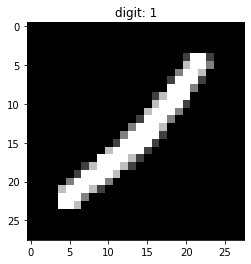

In [3]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray')
plt.title(f'digit: {Y_tr[i]}')

## Linear Regression

In [4]:
print('original X_tr:', X_tr.shape)

# select 500 random examples
n = 500
I = np.random.choice(len(X_tr), n, replace=False)
X = X_tr[I]
Y = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
X = X.reshape(-1,  28*28) # flatten

print('reshaped X:', X.shape)
print('reshaped Y:', Y.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


Now solve:
$$\text{argmin}_\beta ||X \beta - Y||_2$$
for $\beta \in \mathbb{R}^{784}$

### 0.

In [5]:
rank = np.linalg.matrix_rank(X)
print(f"rank: {rank}")

rank: 500


### 1.

In [16]:
X_pinv = np.linalg.pinv(X)
beta_sol = np.matmul(X_pinv,Y)

# double check:
train_error = np.linalg.norm(np.matmul(X,beta_sol)-Y)**2/Y.shape[0]
print(f"train error: {train_error}")
print(f"train acc: {100*np.sum(np.round(np.matmul(X,beta_sol))==Y)/Y.shape[0]}%")

# get the 'test error'
test_error = np.linalg.norm(np.matmul(X_te.reshape(-1,  28*28),beta_sol)-Y_te)**2/Y_te.shape[0]
print(f"test error: {test_error}")
print(f"test acc: {100*np.sum(np.round(np.matmul(X_te.reshape(-1,  28*28),beta_sol))==Y_te)/Y_te.shape[0]}%")


print(f"shape of beta: {beta_sol.shape}") # to double check that everything makes sense

train error: 1.4870180905216459e-28
train acc: 100.0%
test error: 39.8055916440636
test acc: 7.68%
shape of beta: (784,)


Using the Moore-Penrose pseudo-inverse of X, we did find the least-squares solution to the equation $X \beta=Y$ as confirmed by the low 'train error'. This however does not generalize well (as expected, as it was unlikely that a linear model could capture this problem).

### 2.

$\frac{\partial L}{\partial \beta} = (X^TX)\beta-X^TY$

please see the separate python script for the coding part of this problem. I implemented both GD and SGD.

The SGD I implemented does not use minibatches. It does not converge to a useful solution, but I also did not have a lot of time to play around with hyperparams... We shouldn't really expect SGD or GD to give as a better solution for this problem than the approach using the pseudoinverse, as we are still relying on a linear model... The SGD I implemented with the given hyeprparams still does not achieve a training error as low as that of the approach using the pseudoinverse. Minibatches should provide a better tradeoff between accuracy hat can be achieved and computational cost. 

### 3.

In [18]:
# get the condition number of X:

cond = np.linalg.cond(X)
print(f"condition nr of X: {cond}")

condition nr of X: 6797.2089409889695


The condition number of X gives us an idea how sensitive our solution is to changes in beta. The condition number in this example is large, meaning small changes in beta will have a large effect on the resulting Y (and thus the error). This makes the problem ill-suited for SGD or GD (taking a relatively small step along the gradient has a relaively large effect here - less likely to converge / numerically unstable). 